# NOISE: Integral algorithm

In [1]:
import sys
sys.path.append("../src/")
import utils as ut
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import integration as itg
import mittag_leffler as ml

In [2]:
H = 0.6
N = 180
T = 20
h = T/N
id = 11
data_path = "../data_misc/"

path = (f"{data_path}fBM-h-{H}-{id}.hdf5")
noise_path = (f"{data_path}fle-h-{H}-noise-{N}-{id}.hdf5")
BH = ut.read_hdf5_data(path)
dBH = ut.read_hdf5_data(noise_path)
noise = [T*(BH.deets_v[i+1] - BH.deets_v[i])/N for i in range(0,N)]

# FRACTIONAL LANGEVIN EQUATION: Solution

In [3]:
def line(t):
    return t

def solution_sde(t, noise, x0, v0):
    t_ = np.array(t)
    noise_ = np.array(noise)
    return x0 + v0*t_ + itg.convolution(line, noise_, t_)

def solution_fle(t, noise, order, v0):
	t__ = np.array(t)
	noise__ = np.array(noise)
	def nonlinear_term(t):
		z = -t**(2-order)
		return t * ml.mittag_leffler_vector(z, 2-order, 2)
	conv = itg.convolution(nonlinear_term, noise__, t__)
	nonlinear = v0 * nonlinear_term(t__)
	return nonlinear + conv

In [4]:
order = 2 - 2*H
x0 = 0
v0 = 0

delta_t = T/N
t = dBH.deets_t
noise = dBH.deets_v

first_guess = solution_sde(t, noise, x0, v0)
anl = solution_fle(t, noise, order, first_guess[2]/delta_t)

In [5]:
# Numerical solution Next-guess algorithm
df_sol1 = ut.read_hdf5_data(f"{data_path}fle-h-{H}-{N}-{id}.hdf5")

In [6]:
# Finite differences
from fLe import fle

eq = fle(H)
eq.params(T, h = h, v0 = first_guess[2]/delta_t)
eq.external_B_H(np.array(BH.deets_v), t)
eq.get_analytical()
eq.solve()


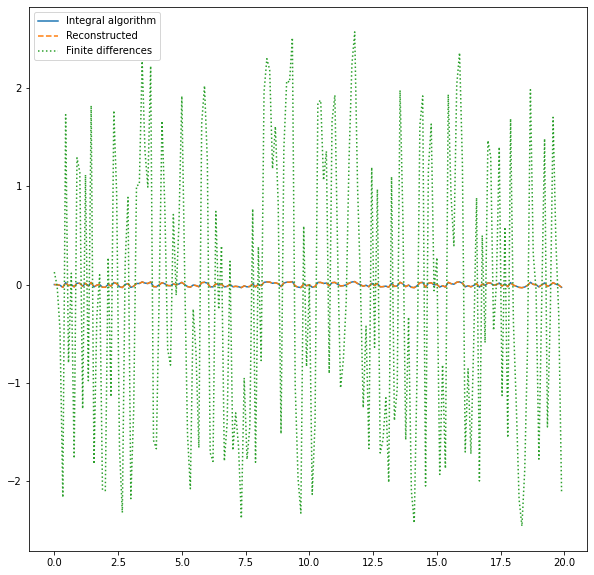

In [8]:
fig, ax = plt.subplots(figsize = (10, 10))
ax.plot(dBH.deets_t, dBH.deets_v, label = "Integral algorithm")
ax.plot(dBH.deets_t, noise, ls = '--', label = "Reconstructed")
ax.plot(dBH.deets_t, eq.dB_H, ls = ':', label = "Finite differences")
ax.legend()


<ipython-input-13-ba7c28f2630c>:1: RuntimeWarning: invalid value encountered in true_divide
  scale_vect = eq.numerical/anl
<ipython-input-13-ba7c28f2630c>:2: RuntimeWarning: invalid value encountered in true_divide
  scale = round(np.mean((eq.numerical/anl)[int(0.8*N):]),2)


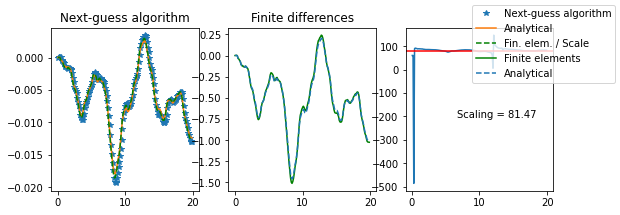

In [13]:
scale_vect = eq.numerical/anl
scale = round(np.mean((eq.numerical/anl)[int(0.8*N):]),2)

fig, ax = plt.subplots(1,3, figsize = (9, 3))
ax[0].plot(t, df_sol1.deets_v, ls = "", marker = "*", label = "Next-guess algorithm")
#ax[0].plot(t, first_guess, ls = ":", marker = "", label = "First guess")
ax[0].plot(t, anl, label = "Analytical")
ax[0].set_title("Next-guess algorithm")
ax[0].plot(t, eq.numerical/scale, label = "Fin. elem. / Scale", ls = "--", color = "green")

ax[1].plot(t, eq.numerical, label = "Finite elements", ls = "-", color = "green")
ax[1].plot(t, eq.analytical, label = "Analytical", ls = "--")
ax[1].set_title("Finite differences")

ax[2].plot(t, scale_vect, label = "", ls = "-")
ax[2].axhline(y = scale, label = "", ls = "-", color = "red")
ax[2].text(0.35, 0.5, f"Scaling = {scale}", transform=ax[2].transAxes, fontsize=10,
        verticalalignment='top')
fig.legend();


The average scale between both algorithms comes from the difference in the definition of noises. For the NGA it was used T/N, while for finite differences it was used 1/(T/N) which actually corresponds to 1/h. This is the right definition.

In [14]:
(eq.dB_H/noise).mean()

81.0